# Rate based implementation of a line-attractor

We implement this as ring-attractor to avoid the complication of boundary conditions, that is dealing with the edges of the network. This simplification does not affect the conclusions of the current study. Whether the neurla implementation in the animal is a ring or line attractor will affect what will happen if we force the animal to exceed its maximum distance that can be represented by the network. Such an experiment is in the plan but not done yet. 

This model is based on the Dunamic Neural Field model of Fundamentals of Computational Neuroscience, Thomas Trappenberg, pp 194

In [18]:
# Import libraries
import numpy as np
# for numerical ODE integration
from scipy import integrate
# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Diplay options:
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

# to display plots in separate windows (interactive)
#%matplotlib qt 


In [19]:
nn = 100              # 100 neurons
dx = 2 * np.pi / nn   # Spatial resolution
sig = 2 * np.pi / 10
C = 0.5               # Inhibition strength

In [20]:
class WeightMatrixGenerator(object):
    
    @staticmethod
    def train_weight_matrix(nn, dx, sig, C):
        """ Train weights matrix. Equivalent to global inhibition with 
            gaussian shaped excitation of nearest neighbours.
            nn : Number of neurons
            C  : Strength of inhibition
            w  : (Returns) a square nnxnn weight matrix
            Method used by Dynamic Neural Field model of Fundamentals of 
            Computational Neuroscience, Thomas Trappenberg, pp 194. """        
        neuron_id = range(nn)       # Neuron numbering 0:99
        i = np.array([neuron_id]).T # Create a column vector. Use list in list because it has to be 2D to transpose it 
        pat = np.zeros((nn, nn))    # Trainning patterns
        for loc in neuron_id:       # For every neuron in the list
            dis = np.minimum(np.abs(i-loc), nn - np.abs(i-loc)) # Circular distances
            pat[:, loc] = np.exp(-(dx*dis) ** 2 / (2 * sig**2)).reshape((1, -1)) # Reshape to 1D vector before assignment

        # Calculate the weight matrix
        w = np.matmul(pat, pat.T)
        w = w / w[1, 1] # Normalise
        w = 4 * (w - C) # Add inhibition and scale

        return w
    

In [21]:
# Training the weight matrix
w = WeightMatrixGenerator.train_weight_matrix(nn, dx, sig, C)


In [22]:
def rnn_ode(t, u):
    ''' The right hand side of the differential equation '''
    # ODE solver for recurrent network
    tau = 1           # Membrane time constant
    tau_inv = 1 / tau # Inverse of membrane time constant
    r = 1 / (1 + np.exp(-u))
    sum1  = np.matmul(w, r) * dx
    udot = tau_inv * (-u + sum1 + I_ext)
    return udot

Text(0.5,0,'Activity')

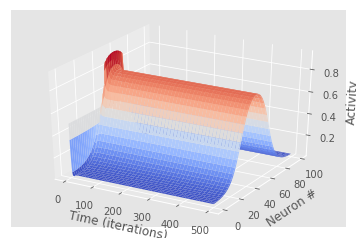

In [23]:
# Arrays to record values into
tall = np.empty((0, 1))
rall = np.empty((0, nn))

# Update with localised input
# integration period
I_ext = np.zeros(nn)
I_ext[(nn/2-np.floor(nn/10)).astype(int):(nn/2+np.floor(nn/10)).astype(int)] = 1
t_simulation_start = 0
t_simulation_end = 10
t_simulation = (t_simulation_start, t_simulation_end)
init_value = np.zeros(nn)
solution = integrate.solve_ivp(rnn_ode, t_simulation, init_value, 'RK45')
t = solution.t
u = solution.y
# Calculate firing rates
r = 1 / (1 + np.exp(-u))

# Record data
tall = np.vstack((tall, t.reshape(1, -1).T))
rall = np.vstack((rall, r.T))

# Update without input
I_ext = np.zeros(nn)
t_simulation_start = 10
t_simulation_end = 500
t_simulation = (t_simulation_start, t_simulation_end)
init_value = u[:,-1] # The new initial value is the last state
solution = integrate.solve_ivp(rnn_ode, t_simulation, init_value, 'RK45')
t = solution.t
u = solution.y
# Calculate firing rates
r = 1 / (1 + np.exp(-u))

# Record data
tall = np.vstack((tall, t.reshape(1, -1).T))
rall = np.vstack((rall, r.T))

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(tall, range(nn))
ax.plot_surface(X, Y, rall.T, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax.set_xlabel('Time (iterations)')
ax.set_ylabel('Neuron #')
ax.set_zlabel('Activity')
